## Augmentation

### Albumentations Augmentation

use in terminal : C:\Users\novin.toos\AppData\Local\Programs\Python\Python310\python.exe -m pip install -U albumentations

In [6]:
KEYPOINT_COLOR = (0, 255, 0)  # Green


def vis_keypoints(image, keypoints, color=KEYPOINT_COLOR, diameter=15):
    image = image.copy()

    for x, y in keypoints:
        cv2.circle(image, (int(x), int(y)), diameter, color, -1)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(image)

In [28]:
import os
import cv2
import numpy as np
import albumentations as A


def strong_augmentation_pipeline_single():
    """Pipeline قوی برای یک تصویر (بدون pair)"""
    return A.Compose([
        A.Rotate(limit=45, p=0.4, border_mode=cv2.BORDER_REFLECT),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.4),

        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=30,
            border_mode=cv2.BORDER_REFLECT,
            p=0.5
        ),

        A.Affine(
            shear={'x': (-20, 20), 'y': (-10, 10)},
            fit_output=True,
            mode=cv2.BORDER_REFLECT,
            p=0.4
        ),

        A.Perspective(
            scale=(0.05, 0.15),
            keep_size=True,
            pad_mode=cv2.BORDER_REFLECT,
            p=0.4
        ),

        A.GaussNoise(var_limit=(5, 20), p=0.2),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
    )


def augment_single_image(dataset_folder, gt_folder, image_name, output_folder, num_aug=3, with_keypoints=False):
    """
    اعمال augmentation فقط روی یک تصویر (مثلاً thermal یا satellite)
    اگر with_keypoints=True باشه، فایل GT مربوط به همون تصویر هم transform میشه.
    """
    os.makedirs(output_folder, exist_ok=True)

    # مسیر تصویر و ground truth
    img_path = os.path.join(dataset_folder, image_name)
    # base_name = os.path.splitext(os.path.basename(image_name))[0]
    base_name = os.path.splitext(os.path.basename(image_name))[0].split("thermal_")[1]
    gt_path = os.path.join(gt_folder, f"{base_name}_ground_truth.txt")

    # خواندن تصویر
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image {img_path}")
        return

    # خواندن keypoints حرارتی
    if with_keypoints and os.path.exists(gt_path):
        kp = np.loadtxt(gt_path)
        if kp.ndim == 1:
            kp = kp.reshape(1, -1)
        keypoints = kp[:, 2:4]  # فقط دو عدد دوم هر ردیف (x_thermal, y_thermal)
    else:
        keypoints = None


    transform = strong_augmentation_pipeline_single()

    # ذخیره نسخه اصلی
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_orig.png"), img)
    if with_keypoints and keypoints is not None:
        np.savetxt(os.path.join(output_folder, f"{base_name}_gt_orig.txt"), keypoints, fmt="%.6f", delimiter=" ")

    # خواندن GT اصلی
    original_kp = np.loadtxt(gt_path)
    if original_kp.ndim == 1:
        original_kp = original_kp.reshape(1, -1)

    # اعمال augmentations
    for i in range(num_aug):
        if keypoints is not None:
            # اعمال transform روی تصویر و keypoints
            transformed = transform(image=img, keypoints=keypoints)
            img_aug = transformed["image"]
            kp_aug = np.array(transformed["keypoints"])
        else:
            # فقط تصویر را transform کن اگر keypoints موجود نیست
            transformed = transform(image=img)
            img_aug = transformed["image"]
            kp_aug = None

        # ذخیره تصویر augment شده
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_aug{i+1}.png"), img_aug)

        # ذخیره keypoints augment شده در صورت وجود
        if kp_aug is not None:
            np.savetxt(
                os.path.join(output_folder, f"{base_name}_gt_aug{i+1}.txt"),
                kp_aug,
                fmt="%.6f",
                delimiter=" "
            )



In [29]:
import os
import glob

dataset_folder = "dataset/thermal"
txt_dir = "dataset/output"
output_folder = "aug_dataset/thermal"

# پیدا کردن همه فایل‌های ground truth
txt_files = sorted(glob.glob(os.path.join(txt_dir, "*.txt")))

for txt_path in txt_files:
    # رد شدن از فایل‌های خالی
    if os.path.getsize(txt_path) == 0:
        continue

    # استخراج شناسه (tile_id)
    tile_id = os.path.splitext(os.path.basename(txt_path))[0].split("_ground_truth")[0]
    image_name = f"thermal_{tile_id}.png"

    print(f"Augmenting thermal tile: {tile_id}")
    print(image_name)
    augment_single_image(
        dataset_folder=dataset_folder,
        gt_folder=txt_dir,
        image_name=image_name,
        output_folder=output_folder,
        num_aug=5,
        with_keypoints=True  
    )


Augmenting thermal tile: tile_10
thermal_tile_10.png


C:\Users\novin.toos\AppData\Local\Temp\ipykernel_19224\1644552184.py:22: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(
C:\Users\novin.toos\AppData\Local\Temp\ipykernel_19224\1644552184.py:29: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(
C:\Users\novin.toos\AppData\Local\Temp\ipykernel_19224\1644552184.py:36: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 20), p=0.2),


Augmenting thermal tile: tile_11
thermal_tile_11.png
Augmenting thermal tile: tile_12
thermal_tile_12.png
Augmenting thermal tile: tile_13
thermal_tile_13.png
Augmenting thermal tile: tile_19
thermal_tile_19.png
Augmenting thermal tile: tile_20
thermal_tile_20.png
Augmenting thermal tile: tile_25
thermal_tile_25.png
Augmenting thermal tile: tile_26
thermal_tile_26.png
Augmenting thermal tile: tile_27
thermal_tile_27.png
Augmenting thermal tile: tile_31
thermal_tile_31.png
Augmenting thermal tile: tile_37
thermal_tile_37.png
Augmenting thermal tile: tile_38
thermal_tile_38.png
Augmenting thermal tile: tile_44
thermal_tile_44.png
Augmenting thermal tile: tile_45
thermal_tile_45.png
Augmenting thermal tile: tile_46
thermal_tile_46.png
Augmenting thermal tile: tile_47
thermal_tile_47.png
Augmenting thermal tile: tile_9
thermal_tile_9.png


### testing the result:

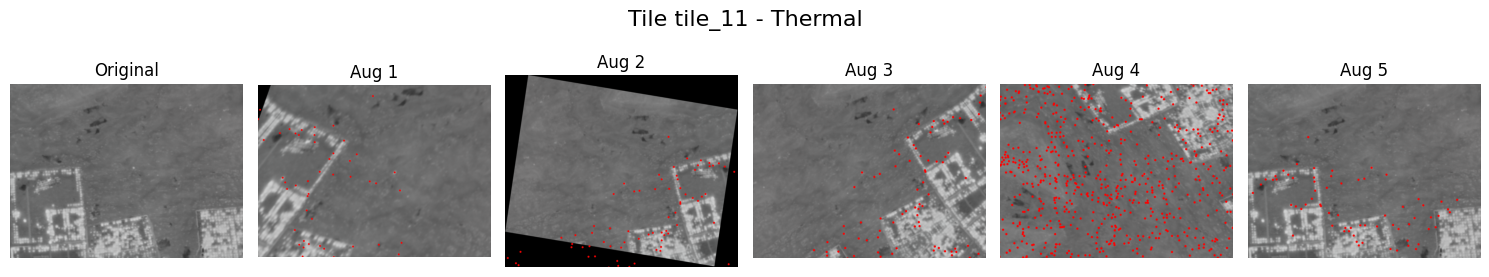

In [47]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_keypoints_on_image(img, kps, color=(255,0,0)):
    """رسم keypoints روی تصویر"""
    img_copy = img.copy()
    for kp in kps:
        x, y = int(kp[0]), int(kp[1])
        cv2.circle(img_copy, (x, y), radius=3, color=color, thickness=-1)
    return img_copy

def inspect_tile_augmentations_with_kp(augmented_folder, dataset_folder, tile_id, num_aug=5):
    """
    نمایش تصویر اصلی Thermal و Satellite و نسخه‌های augment شده همراه با keypoints
    """

    # مسیر تصاویر اصلی
    thermal_orig_path = os.path.join(dataset_folder, "thermal", f"thermal_{tile_id}.png")

    if not os.path.exists(thermal_orig_path):
        print("Original images not found.")
        return

    th_images = [thermal_orig_path]
    th_kp_files = [None]  # برای نسخه اصلی keypoint نداریم
    sat_kp_files = [None]

    # افزودن نسخه‌های augment شده و فایل‌های GT مربوطه
    for n in range(num_aug):
        th_aug = os.path.join(augmented_folder, f"{tile_id}_aug{n+1}.png")
        gt_file = os.path.join(augmented_folder, f"{tile_id}_gt_aug{n+1}.txt")

        if os.path.exists(th_aug) and os.path.exists(gt_file):
            th_images.append(th_aug)
            th_kp_files.append(gt_file)
            sat_kp_files.append(gt_file)
        else:
            print(f"image{gt_file}not found.")

    # نمایش Thermal row
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Tile {tile_id} - Thermal", fontsize=16)
    for i, img_path in enumerate(th_images):
        img = cv2.imread(img_path)
        if img is None:
            print("Not Valid Image")
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # رسم keypoints
        kp_file = th_kp_files[i]
        if kp_file is not None:
            kp_data = np.loadtxt(kp_file)
            if kp_data.ndim == 1:
                kp_data = kp_data.reshape(1, -1)
            # ستون‌های اول (x1,y1) برای thermal
            kp_thermal = kp_data[:, :2]
            img = plot_keypoints_on_image(img, kp_thermal, color=(255,0,0))

        plt.subplot(1, len(th_images), i+1)
        plt.imshow(img)
        label = "Original" if i == 0 else f"Aug {i}"
        plt.title(label)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# -----------------------------
# مثال استفاده
# -----------------------------
augmented_folder = "aug_dataset/thermal"
dataset_folder = "dataset"
tile_id = "tile_11"  
inspect_tile_augmentations_with_kp(augmented_folder, dataset_folder, tile_id)


# SuperPoint Model

## val_test_train

70% train, 15% test, 15% val
an image with its augmented datas will be in one split

In [71]:
import os, shutil, random, glob

data_dir = "aug_dataset"

output_dir = "dataset_split"
os.makedirs(output_dir, exist_ok=True)

for split in ["train", "val", "test"]:
    os.makedirs(f"{output_dir}/{split}/satellite", exist_ok=True)
    os.makedirs(f"{output_dir}/{split}/thermal", exist_ok=True)
    os.makedirs(f"{output_dir}/{split}/keypoints", exist_ok=True)

# پیدا کردن همه‌ی شناسه‌های اصلی
all_ids = sorted(list(set([
    f.split('_')[2] for f in os.listdir(data_dir) if f.startswith("satellite_")
])))

random.seed(42)
random.shuffle(all_ids)

n_total = len(all_ids)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)

train_ids = all_ids[:n_train]
val_ids = all_ids[n_train:n_train+n_val]
test_ids = all_ids[n_train+n_val:]

def copy_files(ids, split):
    for id in ids:
        for n in range(5):  # پنج نسخه augment شده

            src_sat = f"{data_dir}/satellite_tile_{id}_aug{n+1}.png"
            src_th = f"{data_dir}/thermal_tile_{id}_aug{n+1}.png"
            src_kp = f"{data_dir}/ground_truth_tile_{id}_aug{n+1}.txt"

            # destination folders
            dst_sat = f"{output_dir}/{split}/satellite/sat_{id}_{n}.png"
            dst_th = f"{output_dir}/{split}/thermal/th_{id}_{n}.png"
            dst_kp = f"{output_dir}/{split}/keypoints/kp_{id}_{n}.txt"


            if os.path.exists(src_sat):
                shutil.copy(src_sat, dst_sat)
                shutil.copy(src_th, dst_th)
                shutil.copy(src_kp, dst_kp)

        base_sat = f"{data_dir}/satellite_tile_{id}_orig.png"
        base_th = f"{data_dir}/thermal_tile_{id}_orig.png"
        base_kp = f"{data_dir}/ground_truth_tile_{id}_orig.txt"

        bdst_sat = f"{output_dir}/{split}/satellite/sat_{id}.png"
        bdst_th = f"{output_dir}/{split}/thermal/th_{id}.png"
        bdst_kp = f"{output_dir}/{split}/keypoints/kp_{id}.txt"

        if os.path.exists(src_sat):
                shutil.copy(base_sat, bdst_sat)
                shutil.copy(base_th, bdst_th)
                shutil.copy(base_kp, bdst_kp)


copy_files(train_ids, "train")
copy_files(val_ids, "val")
copy_files(test_ids, "test")

print(f"Train: {len(train_ids)*6} samples")
print(f"Val:   {len(val_ids)*6} samples")
print(f"Test:  {len(test_ids)*6} samples")


Train: 84 samples
Val:   18 samples
Test:  18 samples


## finetuning

### DataLoader

In [91]:
import os
import glob
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader

class SuperPointPairDataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: مسیر شامل پوشه‌های sat/, th/, kp/
        """
        self.sat_files = sorted(glob.glob(os.path.join(root_dir, "satellite", "*.png")))
        self.th_files = sorted(glob.glob(os.path.join(root_dir, "thermal", "*.png")))

        kp_npy = sorted(glob.glob(os.path.join(root_dir, "keypoints", "*.npy")))
        kp_txt = sorted(glob.glob(os.path.join(root_dir, "keypoints", "*.txt")))
        self.kp_files = kp_npy + kp_txt

        assert len(self.sat_files) == len(self.th_files) == len(self.kp_files), \
            f"Mismatch in file counts: sat={len(self.sat_files)}, th={len(self.th_files)}, kp={len(self.kp_files)}"

    def __len__(self):
        return len(self.sat_files)

    def load_keypoints(self, path):
        """خواندن نقاط تطبیق‌یافته از فایل .npy یا .txt با ساختار (x1, y1, x2, y2)"""
        ext = os.path.splitext(path)[1].lower()
        if ext == ".npy":
            data = np.load(path)
        elif ext == ".txt":
            data = np.loadtxt(path)
        else:
            raise ValueError(f"Unsupported file format: {ext}")

        data = np.array(data, dtype=np.float32)
        if data.ndim == 1:
            data = data[None, :]

        # اطمینان از داشتن چهار مقدار در هر سطر
        assert data.shape[1] == 4, f"Expected 4 columns (x1,y1,x2,y2), got shape {data.shape}"

        # جدا کردن نقاط هر تصویر
        kp_sat = data[:, :2]  # (x1, y1)
        kp_th = data[:, 2:]   # (x2, y2)

        return kp_sat, kp_th

    def __getitem__(self, idx):
        # خواندن تصاویر
        img_sat = cv2.imread(self.sat_files[idx], cv2.IMREAD_GRAYSCALE)
        img_th = cv2.imread(self.th_files[idx], cv2.IMREAD_GRAYSCALE)

        if img_sat is None or img_th is None:
            raise ValueError(f"Error reading image pair index {idx}")

        # خواندن keypoints
        kp_sat, kp_th = self.load_keypoints(self.kp_files[idx])
        
        # تبدیل به Tensor
        img_sat = torch.from_numpy(img_sat).unsqueeze(0).float() / 255.0
        img_th = torch.from_numpy(img_th).unsqueeze(0).float() / 255.0
        kp_sat = torch.from_numpy(kp_sat)
        kp_th = torch.from_numpy(kp_th)

        return img_sat, img_th, kp_sat, kp_th


In [74]:
train_dataset = SuperPointPairDataset("dataset_split/train")
val_dataset = SuperPointPairDataset("dataset_split/val")
test_dataset = SuperPointPairDataset("dataset_split/test")

testing:

Image Satellite: torch.Size([1, 480, 640]) 0.3294117748737335 0.9058823585510254
Image Thermal: torch.Size([1, 480, 640]) 0.10196078568696976 0.8196078538894653
Keypoints Satellite: torch.Size([24, 2])
Keypoints Thermal: torch.Size([24, 2])


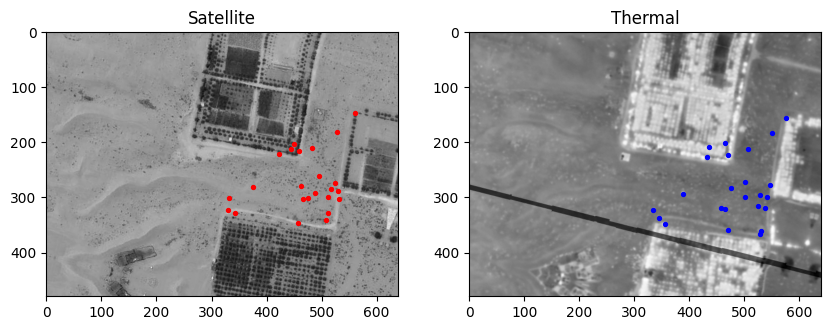

In [89]:
import matplotlib.pyplot as plt

# یکی از دیتاست‌ها (مثلاً train)
dataset = train_dataset

# گرفتن یک نمونه تصادفی
img_sat, img_th, kp_sat, kp_th = dataset[10]  

print("Image Satellite:", img_sat.shape, img_sat.min().item(), img_sat.max().item())
print("Image Thermal:", img_th.shape, img_th.min().item(), img_th.max().item())
print("Keypoints Satellite:", kp_sat.shape)
print("Keypoints Thermal:", kp_th.shape)

# نمایش تصویری برای اطمینان از هماهنگی
img_sat_np = img_sat.squeeze(0).numpy()
img_th_np = img_th.squeeze(0).numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_sat_np, cmap='gray')
plt.scatter(kp_sat[:,0], kp_sat[:,1], c='r', s=8)
plt.title("Satellite")

plt.subplot(1,2,2)
plt.imshow(img_th_np, cmap='gray')
plt.scatter(kp_th[:,0], kp_th[:,1], c='b', s=8)
plt.title("Thermal")

plt.show()


In [92]:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(len(train_loader), len(val_loader), len(test_loader))


21 5 5


### Model

Backbone:
conv1a/b, conv4a/b → استخراج ویژگی‌های چندسطحی

Head:
1- Detector head: convPa, convPb → تولید heatmap نقاط کلیدی
2- Descriptor head: convDa, convDb → تولید descriptor map (توضیف راجب ناحیه اطراف هر نقطه)

Backbone Encoder

| نام لایه | چه نوع ویژگی‌هایی می‌گیره؟                         |
| -------- | -------------------------------------------------- |
| conv1a/b | لبه‌ها، گوشه‌ها، رنگ‌ها — ویژگی‌های خیلی پایه‌ای   |
| conv2a/b | ترکیب لبه‌ها — مثل بافت‌ها (texture)               |
| conv3a/b | الگوهای بزرگ‌تر و شکل‌های موضعی                    |
| conv4a/b | الگوهای معنایی (مثلاً اشیاء خاص، ساختار کلی تصویر) |

به این بخش می‌گیم encoder چون تصویر رو به یک نمایش فشرده از ویژگی‌ها تبدیل می‌کنه.

conv1 - conv3 → Freeze -> فیچر های مشترک در همه ی تصاویر هستند مثل لبه ها 
conv4 و headها → Unfreeze

In [14]:
import sys
import os

project_path = r"F:\IDM\SuperPoint\dataset\CGTD_Tool\SuperPoint-master"

if project_path not in sys.path:
    sys.path.append(project_path)

from superpoint_ml import SuperPoint as SuperPointNet

In [ ]:
import torch

path_ckpt_ml = r"F:\IDM\SuperPoint\dataset\CGTD_Tool\SuperPoint-master\weights\superpoint_v1_ml.pth"

model = SuperPointNet()
# بارگزاری وزن های مدل
checkpoint = model.load(path_ckpt_ml, map_location='cpu')

model.load_state_dict(checkpoint)

In [ ]:
model = SuperPoint(config)
model.freeze_backbone()
model.unfreeze_heads()
